# Chapter 7 - Recap

In [1]:
library(rethinking)
data(WaffleDivorce)
d <- WaffleDivorce
d$A <- standardize(d$MedianAgeMarriage)
d$D <- standardize(d$Divorce)
d$M <- standardize(d$Marriage)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: parallel

rethinking (Version 2.13)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent




In [4]:
m5.1 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 0.2),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data = d
)

m5.2 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM * M,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data = d
)

m5.3 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- a + bM*M + bA*A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d
)

## Assessing predictive performance with Information Criteria (IC) and Cross Validation (CV)

Information criteria are a measure to assess predictive performance. But take care: Information criteria will happily select a confounded model.  
Among the most popular information criteria are:

*  **Akaike IC (AIC)** is the original measure which is only reliable in case priors are flat, the posterior is aproximately multivariate Gaussian and the sample size N is much greater than the number of parameters k. It isn't of practical use anymore.
* BIC:
*   **Deviance IC (DIC)** is more general than AIC but still requires that the posterior is multivariate Gaussian and that N >> k
*  **Widely Applicable IC (WAIC)** provides an approximation of the out-of-sample deviance, which is quite accurate in many contexts

Cross validation computes out-of-sample deviance by taking one part of the data to fit the model and then predicts the other part of the data. The most popular form is Leave-one-out CV, which in its original form can be very resource consuming.

* **CV** Divide the data into multiple sets and use all but one set to fit the model and predict on the last set. Do this for all combinations of sets. 
*  **Pareto-smoothed importance sampling CV (PSIS)** uses importance sampling, which means it computes the importance of each data point. Importance is a way to measure how likely or unlikely a particular datum is according to the model. The more unlikely, the more important the observation as it will influence the parameter estimation to a greater degree than likely observations.

The recommendation is to use PSIS and WAIC in parallel and compare their scores.

In [8]:
compare(m5.1, m5.2, m5.3, func=PSIS)

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.

Some Pareto k values are high (>0.5). Set pointwise=TRUE to inspect individual points.



,PSIS,SE,dPSIS,dSE,pPSIS,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5.1,128.9193,15.86889,0.0000000,NA,5.338472,0.583789483
m5.3,129.6058,15.20003,0.6864984,1.446821,6.043648,0.414176092
m5.2,140.2379,10.78921,11.3186545,12.055700,3.554500,0.002034425


The warnings indicate the presence of highly influential observations. To analyze further, we compute PSIS and WAIC pointwise.

In [12]:
PSIS_m5.3 <- PSIS(m5.3, pointwise=TRUE)

Some Pareto k values are very high (>1). Set pointwise=TRUE to inspect individual points.



In [13]:
WAIC_m5.3 <-  WAIC(m5.3, pointwise=TRUE)

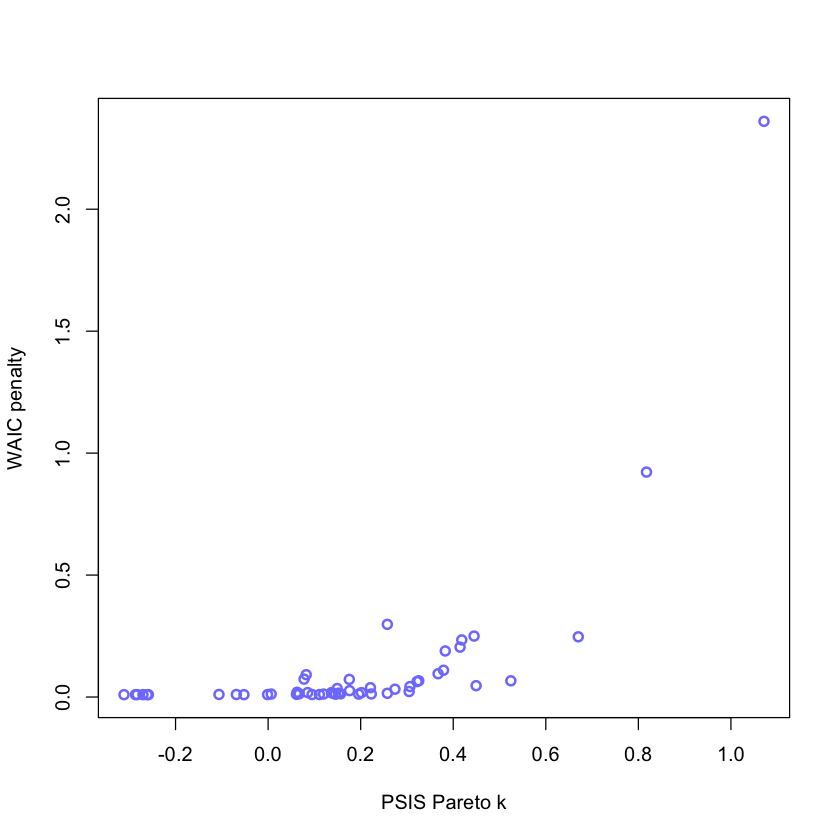

In [14]:
plot(PSIS_m5.3$k, WAIC_m5.3$penalty, xlab="PSIS Pareto k", ylab="WAIC penalty", col=rangi2, lwd=2)

## Thick tails - the Student-t distribution

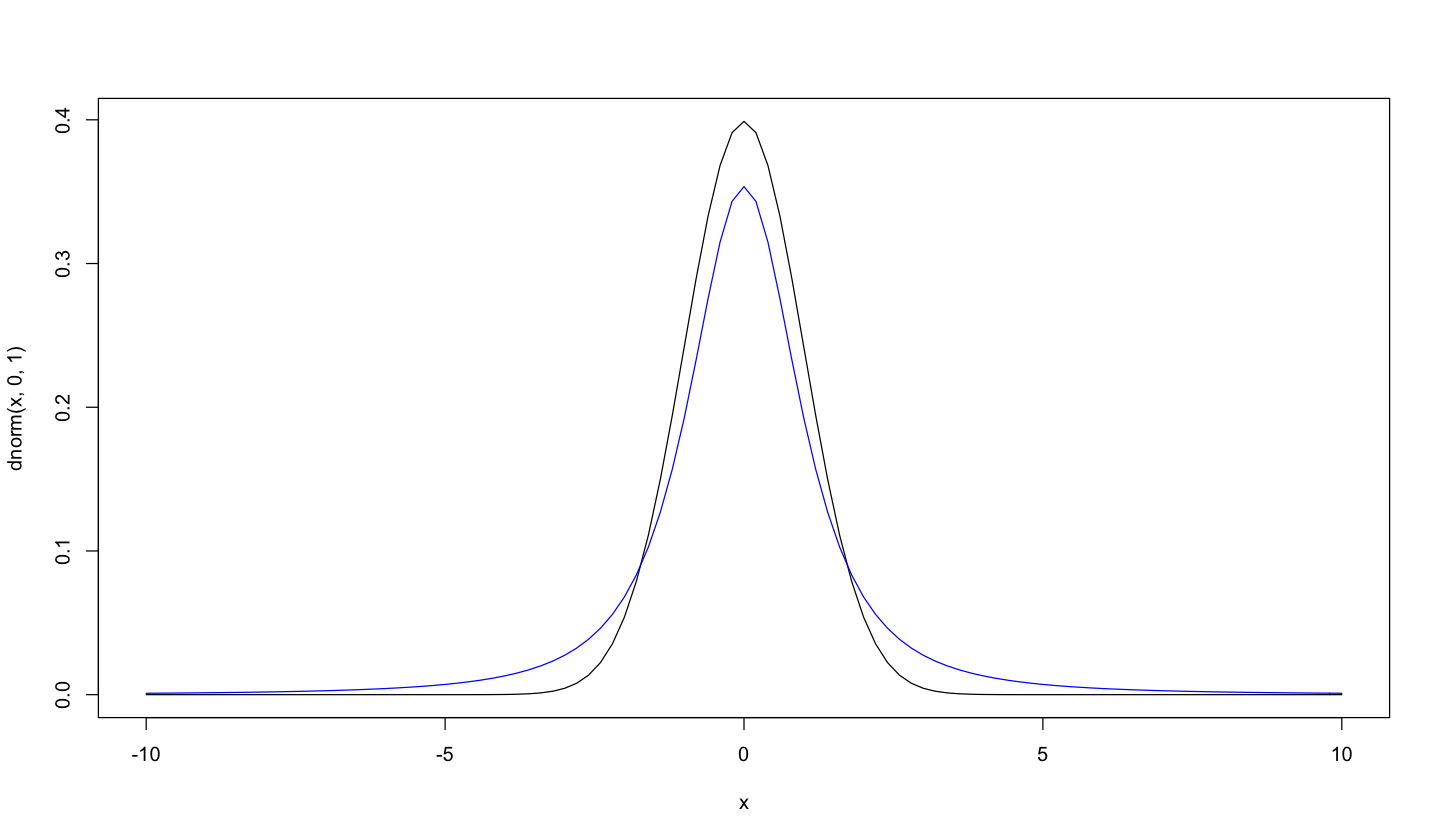

In [37]:
options(repr.plot.width=12, repr.plot.height=7)
curve(dnorm(x, 0, 1),  from=-10, to=10)
curve(dstudent(x, 2, 0, 1),add=TRUE, col="blue")

In [38]:
m5.3t <- quap(
    alist(
        D ~ dstudent(2, mu, sigma),
        mu <- a + bM*M + bA*A,
        a ~ dnorm(0, 0.2),
        bM ~ dnorm(0, 0.5),
        bA ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ), data=d   
)

In [39]:
compare(m5.3, m5.3t)

,WAIC,SE,dWAIC,dSE,pWAIC,weight
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m5.3,128.9082,14.34855,0.000000,NA,5.643963,0.9254549
m5.3t,133.9459,11.80962,5.037762,6.746403,6.972468,0.0745451


In [42]:
precis(m5.3)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-3.869533e-06,0.09707637,-0.1551507,0.1551429
bM,-6.533849e-02,0.15077407,-0.3063046,0.1756276
bA,-6.134707e-01,0.15098476,-0.8547735,-0.3721679
sigma,7.851216e-01,0.07784431,0.6607113,0.9095318


In [43]:
precis(m5.3t)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.015070212,0.09943824,-0.1438513,0.1739917
bM,0.003733739,0.21185159,-0.3348460,0.3423135
bA,-0.701161111,0.13045933,-0.9096603,-0.4926619
sigma,0.552699405,0.08005557,0.4247551,0.6806437
